In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random

In [2]:
import layers as custom_layers

In [3]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# File Paths
imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [5]:
trainDataPath = "./affineTrainingData/affine{}.npz"
trainDataSize = 2000
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = fixedImg / np.max(fixedImg)
fixedImg = fixedImg.astype('float32')
fixedImg = np.expand_dims(fixedImg, axis=-1)

def data_generator(batch_size = 5):
    # TODO: Batchify the funciton.
    while True:
        imgPair_batch = np.zeros((batch_size, *fixedImg.shape[:-1], 2))
        fixedImg_batch = np.zeros((batch_size, *fixedImg.shape))
        tgtAffineTrf_batch = np.zeros((batch_size, 12))
        for i in range(batch_size):
            idx = random.randrange(trainDataSize)
            inputObj = np.load(trainDataPath.format(idx))
            movingImg = inputObj['img']
            movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = movingImg.astype('float32')
            imgPair = np.concatenate([movingImg, fixedImg], axis=3)
            imgPair_batch[i] = imgPair

            tgtAffineTrf = inputObj['trf']
            tgtAffineTrf = tgtAffineTrf.astype('float32')
            tgtAffineTrf_batch[i] = tgtAffineTrf
            fixedImg_batch[i] = fixedImg
        
        yield (imgPair_batch, [fixedImg_batch, tgtAffineTrf_batch])

## NN with labels as fixed images

In [6]:
# Get rid of the batch dimension
# imgPairShape = list(fixedImg.shape)[1:]
# # Change the channel dimension to get the image pair shape
# imgPairShape[-1] = 2
inputs = keras.Input(shape = (*fixedImg.shape[:-1], 2))
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]

bn = layers.BatchNormalization()

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation="relu")(moving_input)
conv_0 = bn(conv_0, training=True)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), strides=(2, 2, 2), activation="relu")(conv_0)
conv_1 = layers.BatchNormalization()(conv_1)
print("conv_1: {}".format(conv_1.shape))
# filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
# print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation="relu")(conv_1)
conv_2 = layers.BatchNormalization()(conv_2, training=True)
print("conv_2: {}".format(conv_2.shape))
# filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
# print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), strides=(1, 2, 2), activation="relu")(conv_2)
conv_3 = layers.BatchNormalization()(conv_3)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation="relu")(conv_3)
conv_4 = layers.BatchNormalization()(conv_4)
print("conv_4: {}".format(conv_4.shape))

f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation="relu")(fixed_input)
f_conv_0 = layers.BatchNormalization()(f_conv_0)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), strides=(2, 2, 2), activation="relu")(f_conv_0)
f_conv_1 = layers.BatchNormalization()(f_conv_1)
# f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation="relu")(f_conv_1)
f_conv_2 = layers.BatchNormalization()(f_conv_2)
# f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), strides=(1, 2, 2), activation="relu")(f_conv_2)
f_conv_3 = layers.BatchNormalization()(f_conv_3)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation="relu")(f_conv_3)
f_conv_4 = layers.BatchNormalization()(f_conv_4)

concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
print(concat_feats.shape)

flattened = layers.Flatten()(concat_feats)
dense_0 = layers.Dense(1024, activation="relu")(flattened)
dense_0 = layers.Dropout(0.2)(dense_0)
dense_1 = layers.Dense(256, activation="relu")(dense_0)
dense_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(64, activation="relu")(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

conv_0: (None, 47, 113, 113, 4)
conv_1: (None, 21, 49, 49, 8)
conv_2: (None, 16, 42, 42, 16)
conv_3: (None, 13, 18, 18, 24)
conv_4: (None, 10, 15, 15, 32)
(None, 10, 15, 15, 64)
Instructions for updating:
Use fn_output_signature instead
(None, 52, 256, 256, 1)


In [7]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="combined_model")
model.summary()

Model: "combined_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52, 256, 256 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 52, 256, 256) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 52, 256, 256) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 52, 256, 256, 0           tf.__operators__.getitem[0][0]   
_____________________________________________________________________________________

In [11]:
dataGen = data_generator(batch_size = 1)
moving_test, label_test = next(dataGen)
print(moving_test.shape)
(warped_test, affine_pred_test) = model(moving_test)
print(label_test[1])
print(label_test[1].dtype)
print(affine_pred_test)
mse = tf.keras.losses.MeanSquaredError()
print(mse(label_test[1], affine_pred_test))

(1, 52, 256, 256, 2)
[[  1.07562971   0.07481706   0.02881351  -2.73810554  -0.06504187
    1.02170742  -0.2249005  -10.15680599  -0.03637582   0.18872629
    0.86789048 -26.2827282 ]]
float64
tf.Tensor(
[[ 1.64121389e-04  1.82616971e-02  1.16574496e-01 -1.37251392e-01
   1.10393360e-01 -1.30815506e-01  1.17821954e-01 -2.63863176e-01
   1.19749129e-01  5.49131483e-02  1.67303443e-01 -4.47249934e-02]], shape=(1, 12), dtype=float32)
tf.Tensor(66.35373, shape=(), dtype=float32)


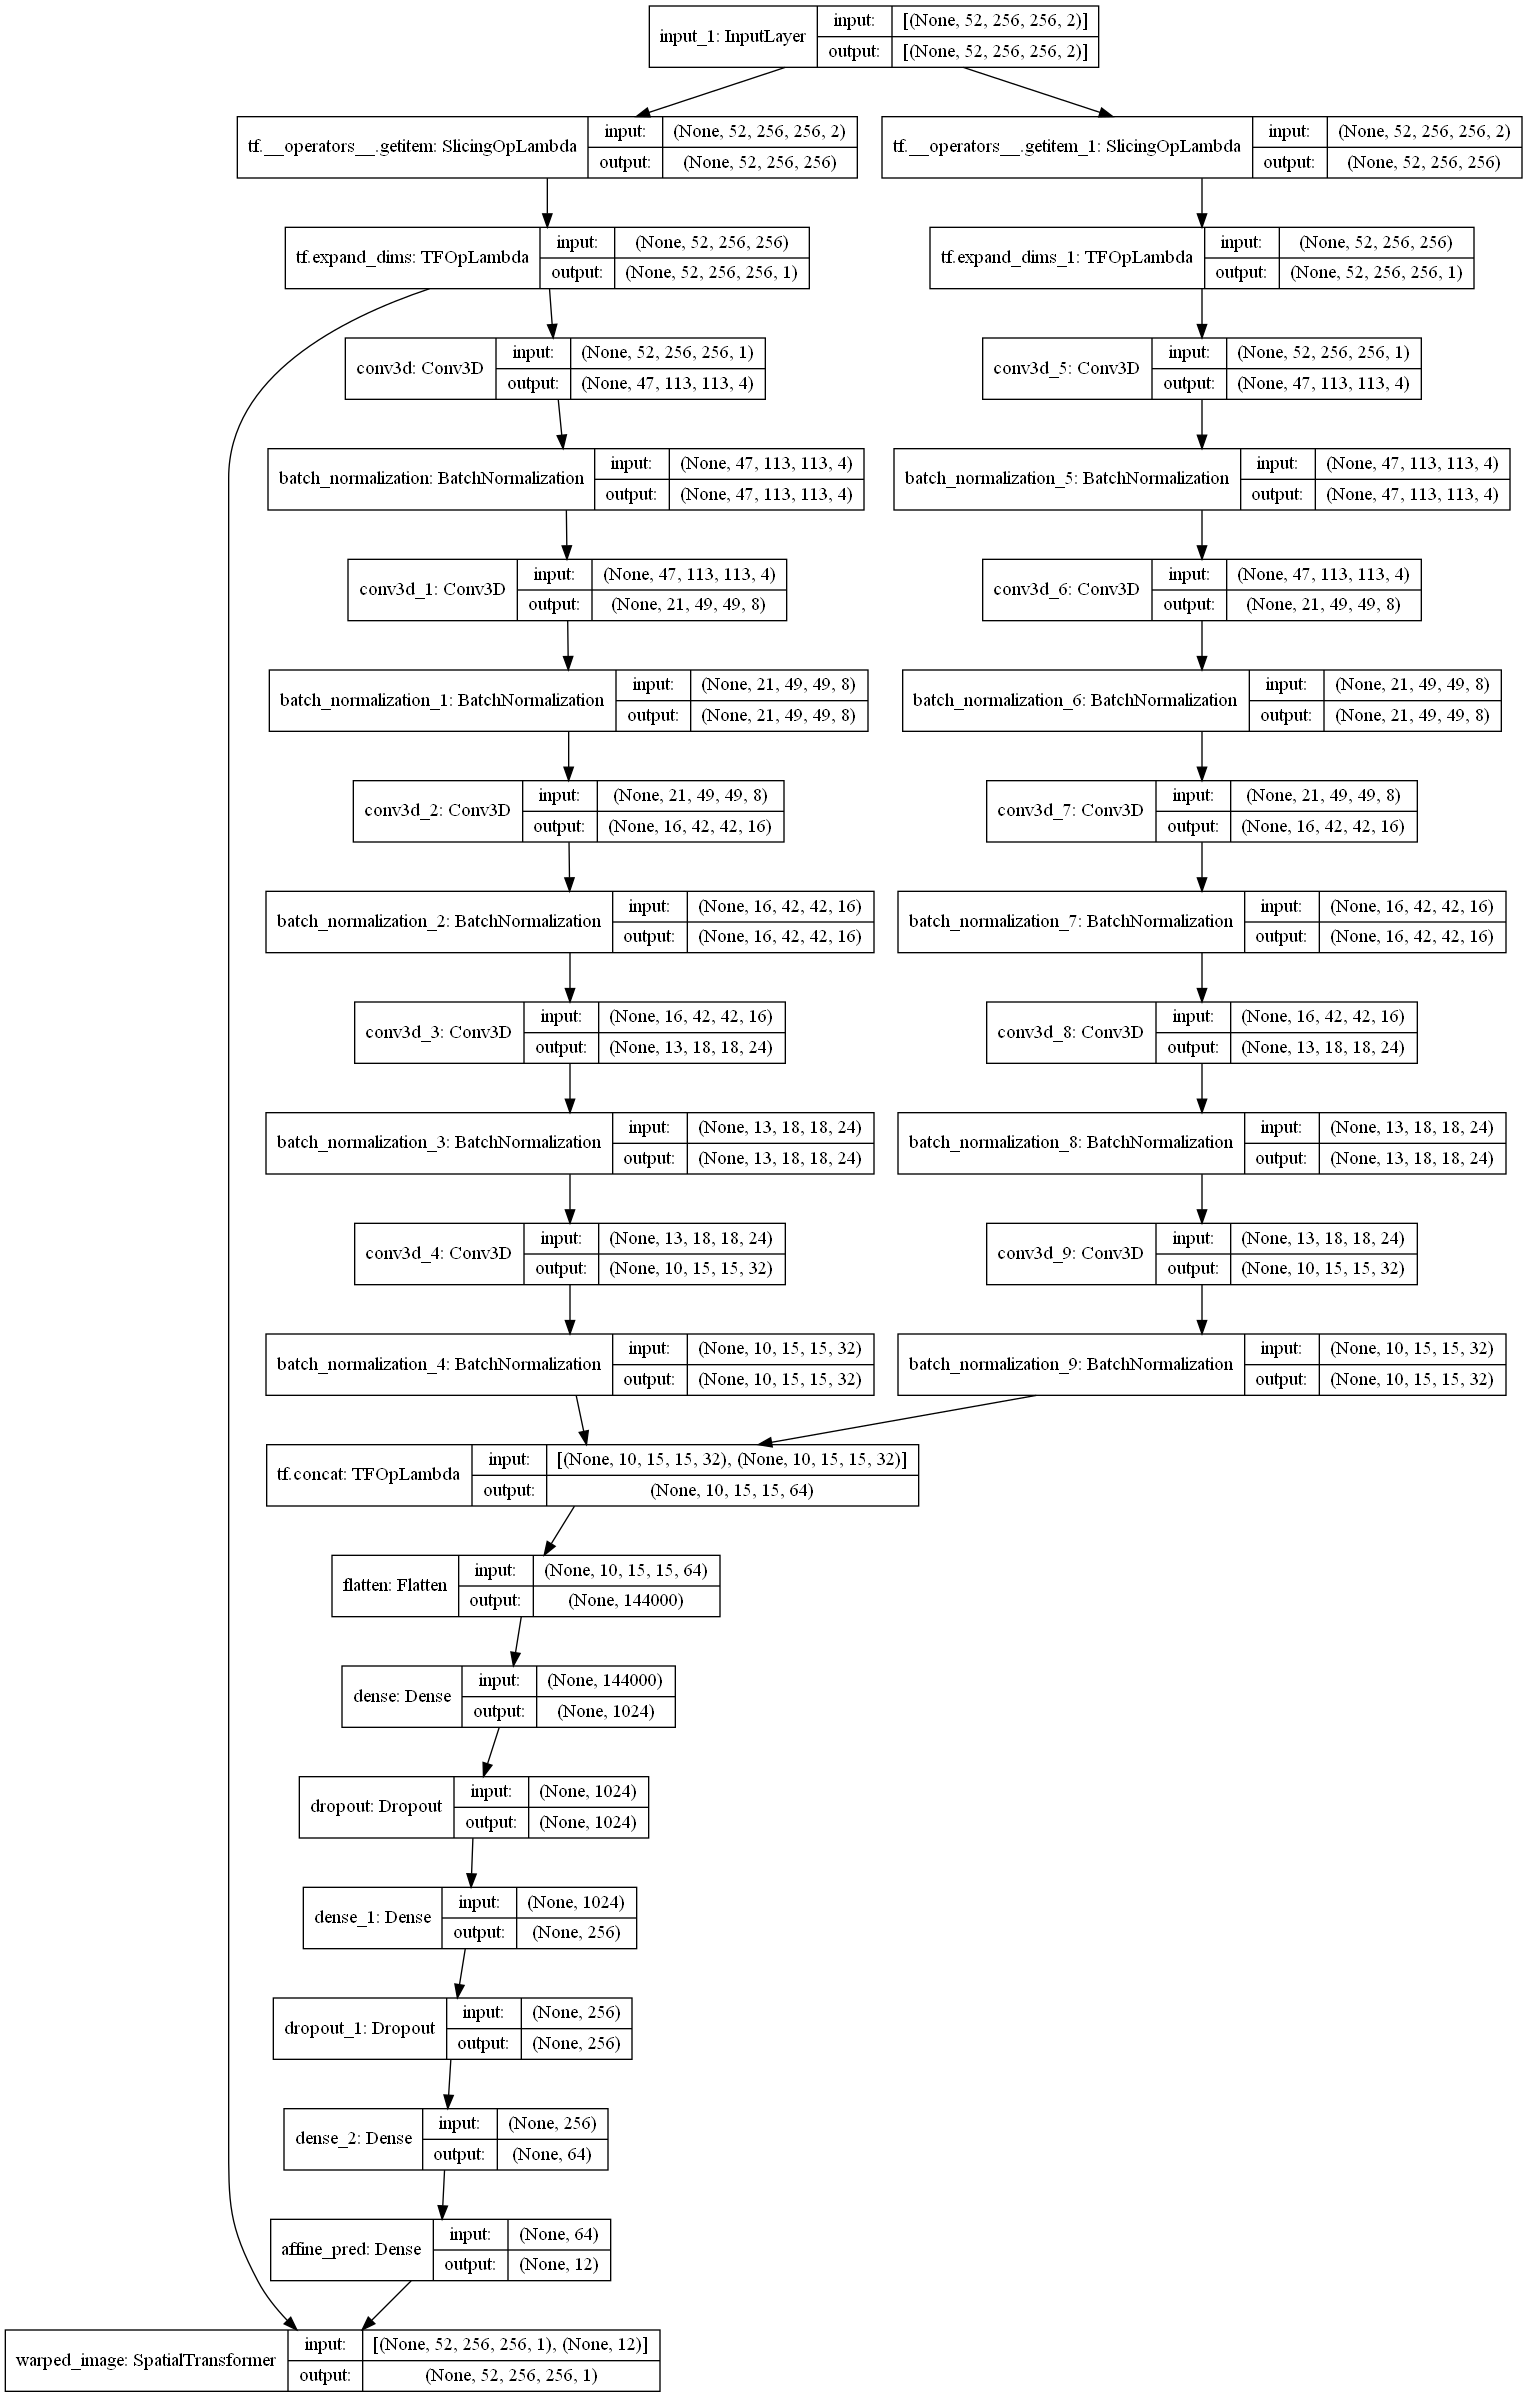

In [12]:
keras.utils.plot_model(model, "test.png", show_shapes=True)

In [13]:
lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
# loss_object = tf.keras.losses.MeanSquaredError()

loss_history = []
save_callback = ModelCheckpoint('./checkpoints/{epoch:02d}.h5')

In [ ]:
"""
y = (deformed_img, affine_trf)
"""
def affine_loss(y_actual, y_pred):
    y_actual = y_actual[0]
    y_pred = y_pred[0]
    tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
    predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
    tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
    predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
    tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
    predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
    mse = tf.keras.losses.MeanSquaredError()
    diag_loss = mse(tgtDiag, predDiag)
    corner_loss = mse(tgtCorner, predCorner)
    translation_loss = mse(tgtTranslation, predTranslation)
    return corner_loss * 10 + diag_loss * 10 + translation_loss

In [14]:
model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred":"mean_squared_error"},
#               loss_weights={"warped_image":1, "affine_pred":1},
              run_eagerly=True)

In [15]:
dataGen = data_generator()

In [16]:
model.fit(dataGen, epochs=20, steps_per_epoch=trainDataSize, callbacks=[save_callback])

Epoch 1/20
2000/2000 [==============================] - 4321s 2s/step - loss: 1029.5671 - warped_image_loss: 0.0773 - affine_pred_loss: 1029.4899
Epoch 2/20
2000/2000 [==============================] - 4313s 2s/step - loss: 16.9440 - warped_image_loss: 0.0831 - affine_pred_loss: 16.8609
Epoch 3/20
2000/2000 [==============================] - 4319s 2s/step - loss: 19747.5642 - warped_image_loss: 0.0828 - affine_pred_loss: 19747.4815
Epoch 4/20
2000/2000 [==============================] - 4315s 2s/step - loss: 14.5573 - warped_image_loss: 0.0828 - affine_pred_loss: 14.4745
Epoch 5/20
2000/2000 [==============================] - 4312s 2s/step - loss: 292.7872 - warped_image_loss: 0.0757 - affine_pred_loss: 292.7114
Epoch 6/20
2000/2000 [==============================] - 4415s 2s/step - loss: 13.7678 - warped_image_loss: 0.0825 - affine_pred_loss: 13.6852
Epoch 7/20
 886/2000 [============>.................] - ETA: 40:31 - loss: 72344.7499 - warped_image_loss: 0.0511 - affine_pred_loss: 72

KeyboardInterrupt: 

## Test model (output == warpedImg)

In [17]:
testModel = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred])

In [18]:
# testModel.load_weights('./checkpoints/epoch_{}'.format(epochs-1))
testModel.load_weights('./checkpoints/06.h5')

In [19]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)
print(label_test[1])
print(label_test[1].dtype)
print(affine_pred_test)
mse = tf.keras.losses.MeanSquaredError()
print(mse(label_test[1], affine_pred_test))

[[ 9.00595903e-01  3.56275178e-02  2.35815421e-02 -2.83203793e+00
  -3.43968309e-02  8.94554973e-01 -3.78739052e-02 -1.15912991e+01
  -2.98874322e-02  4.43403721e-02  1.07443190e+00 -1.99491906e+00]
 [ 1.00806272e+00  2.14299690e-02  3.36881392e-02 -4.50645304e+00
  -1.04462272e-02  1.05983603e+00 -3.61605078e-01 -1.41911592e+01
  -4.38592024e-02  3.67572159e-01  1.07859218e+00 -2.19158249e+01]
 [ 9.67945695e-01  1.90322548e-02  2.66036596e-02 -1.13512242e+00
  -7.80292181e-03  8.74229074e-01 -3.41522396e-01 -3.19288492e+00
  -2.87453197e-02  3.19128931e-01  8.17562997e-01 -1.30391617e+01]
 [ 1.01584029e+00  2.34557893e-02  3.80493253e-02 -4.63141203e+00
  -2.20444854e-02  1.02470911e+00 -4.31462489e-02 -1.06045313e+01
  -4.29771245e-02  4.61888984e-02  1.11892915e+00 -2.94763374e+01]
 [ 1.05795205e+00  4.68530767e-02  2.22408883e-02 -4.17032003e+00
  -3.76009829e-02  8.79236698e-01 -6.36174604e-02 -1.98494816e+01
  -2.46431958e-02  7.26839602e-02  1.01910722e+00 -2.72969074e+01]]
floa

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()